In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
BATCHSIZE = 128
EPOCH = 35
LATENT_DIM = 500
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 22000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

In [ ]:
eng = []
man = []
man_inputs = []
count = 0

# preprocess the translation file
for line in open('/content/drive/MyDrive/ita-eng/ita.txt'):
    if '\t' not in line:
        continue

    count += 1
    if (count > SAMPLES):
        break

    # split original and translation into lists
    e, m, _ = line.rstrip().split('\t')
    eng.append(e)
    man.append(m + ' <eos>')
    man_inputs.append('<sos> ' + m)

    if (count % 2000 == 0):
        print ('Sample Count: {}.'.format(count))

Sample Count: 2000.
Sample Count: 4000.
Sample Count: 6000.
Sample Count: 8000.
Sample Count: 10000.
Sample Count: 12000.
Sample Count: 14000.
Sample Count: 16000.
Sample Count: 18000.
Sample Count: 20000.
Sample Count: 22000.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize input and generate idx map
tok_in = Tokenizer(num_words=MAX_WORD_NUM)
tok_in.fit_on_texts(eng)
eng_seq = tok_in.texts_to_sequences(eng)
word2idx_in = tok_in.word_index
max_in_len = max(len(s) for s in eng_seq)

print("Number of input tokens: {}".format(len(word2idx_in)))
print("Maximum input sequence length: {}".format(max_in_len))

# tokenize output and generate idx map
tok_out = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tok_out.fit_on_texts(man + man_inputs)
man_seq = tok_out.texts_to_sequences(man)
man_seq_inputs = tok_out.texts_to_sequences(man_inputs)
word2idx_out = tok_out.word_index
max_out_len = max(len(s) for s in man_seq)
out_word_num = len(word2idx_out) + 1

print("Number of output tokens: {}".format(len(word2idx_out)))
print("Maximum output sequence length: {}".format(max_out_len))

Number of input tokens: 2486
Maximum input sequence length: 5
Number of output tokens: 8038
Maximum output sequence length: 8


In [ ]:
from keras.preprocessing.sequence import pad_sequences

eng_seq_padded = pad_sequences(eng_seq, maxlen=max_in_len)
man_seq_padded = pad_sequences(man_seq, maxlen=max_out_len, padding='post')
man_seq_inputs_padded = pad_sequences(man_seq_inputs, maxlen=max_out_len, padding='post')

In [ ]:
wordVec = {}

print('Loading wordVec')

# load in word vectors in a dict
with open('/content/drive/MyDrive/glove.6B.100d.txt') as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec

print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [ ]:
wordNum = min(MAX_WORD_NUM, len(word2idx_in) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

# create word embedding by fetching each word vector
for tok, idx in word2idx_in.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [ ]:
man_target_one_hot = np.zeros((len(eng), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(man_seq_padded):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

In [ ]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import keras.backend as K
from keras.models import Model

# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(out_word_num, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(out_word_num, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

In [ ]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    """
    h: encoder encoded hidden states at all time.
    prevOut: output at the previous time (word).
    An iteration of attention.
    """
    prevOutRepeat = repeat_attn(prevOut) # Tx, LATENT_DIM_DECODE
    total = concat_attn([h, prevOutRepeat]) # Tx, LATENT_DIM_DECODE + LATENT_DIM * 2
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])

    return context

In [ ]:
s = s0
c = c0

# Iterate attention Ty times
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s)

    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)

    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])

    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

In [ ]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [ ]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [ ]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

In [ ]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc])

# Define empty s0 and c0
init_s = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))
init_c = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))

# Train
history = attnModel.fit(
    x=[eng_seq_padded, man_seq_padded, init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH,
    validation_split=0.22
)

Epoch 1/35
135/135 [==============================] - 50s 200ms/step - loss: 5.6810 - acc: 0.2812 - val_loss: 5.6802 - val_acc: 0.2501
Epoch 2/35
135/135 [==============================] - 14s 105ms/step - loss: 4.8955 - acc: 0.3198 - val_loss: 5.4562 - val_acc: 0.2796
Epoch 3/35
135/135 [==============================] - 13s 99ms/step - loss: 4.5078 - acc: 0.3472 - val_loss: 5.2543 - val_acc: 0.3080
Epoch 4/35
135/135 [==============================] - 13s 93ms/step - loss: 4.0816 - acc: 0.3836 - val_loss: 5.0645 - val_acc: 0.3397
Epoch 5/35
135/135 [==============================] - 13s 99ms/step - loss: 3.6990 - acc: 0.4113 - val_loss: 4.9348 - val_acc: 0.3638
Epoch 6/35
135/135 [==============================] - 14s 102ms/step - loss: 3.3600 - acc: 0.4340 - val_loss: 4.8454 - val_acc: 0.3783
Epoch 7/35
135/135 [==============================] - 13s 93ms/step - loss: 3.0513 - acc: 0.4534 - val_loss: 4.8038 - val_acc: 0.3875
Epoch 8/35
135/135 [==============================] - 13s 9

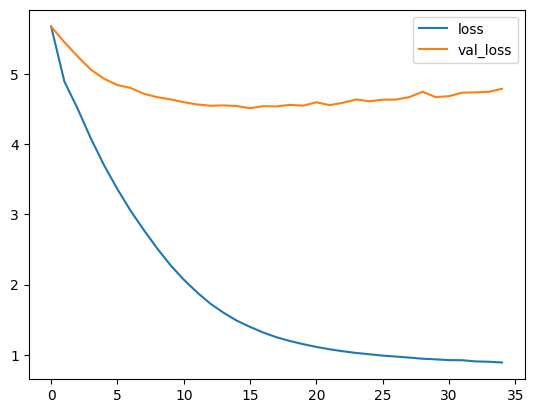

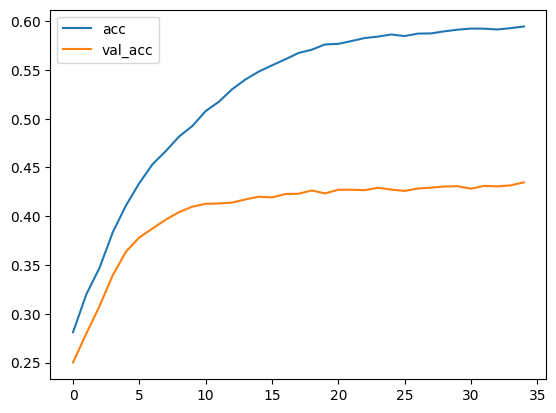

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
attnModel.save('attention_model_35_man.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_in_len, LATENT_DIM * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(
    inputs=[decoder_in_inf, encoder_out_inf, s0, c0],
    outputs=[pred_out, s, c]
)

In [ ]:
idx2word_in = {b:a for a, b in word2idx_in.items()}
idx2word_out = {b:a for a, b in word2idx_out.items()}

def inference(eng_seq):
    # Encode
    encoder_output = encoder_inf.predict(eng_seq)

    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_out['<sos>']

    # init
    eos = word2idx_out['<eos>']
    s0 = np.zeros((1, LATENT_DIM_DECODER))
    c0 = np.zeros((1, LATENT_DIM_DECODER))

    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])

        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_out[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok

    sentence = ' '.join(output_seq)
    return sentence

In [ ]:
for _ in range(20):
    i = np.random.choice(len(eng))
    eng_sen = eng_seq_padded[i:i+1]
    man_pred = inference(eng_sen)

    print('--------------------------------------')
    print('English: {}'.format(eng[i]))
    print('Prediction: {}'.format(man_pred))
    print('Ground truth: {}'.format(man[i]))

1/1 [==============================] - 0s 19ms/step
--------------------------------------
English: Tom grinned.
Prediction: tom fece un gran gran
Ground truth: Tom ha fatto un gran sorriso. <eos>
1/1 [==============================] - 0s 20ms/step
--------------------------------------
English: Is that a bird?
Prediction: è un cervo?
Ground truth: È un uccello? <eos>
1/1 [==============================] - 0s 21ms/step
--------------------------------------
English: Is Tom hungry?
Prediction: tom è affamato?
Ground truth: Tom ha fame? <eos>
1/1 [==============================] - 0s 19ms/step
--------------------------------------
English: I'm committed.
Prediction: sono sono
Ground truth: Io sono devoto. <eos>
1/1 [==============================] - 0s 20ms/step
--------------------------------------
English: Tom wanted it.
Prediction: tom lo voleva.
Ground truth: Tom lo voleva. <eos>
1/1 [==============================] - 0s 21ms/step
--------------------------------------
English: Are